In [145]:
%matplotlib nbagg
%matplotlib inline
import MDAnalysis as mda
import MDAnalysis.analysis.leaflet
import matplotlib
import numpy as np
from scipy.optimize import curve_fit
from numpy.polynomial import polynomial as P
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import nglview as nv
import copy
import warnings
warnings.filterwarnings('ignore')

# name and files for the simulation studied

name = '_DPPC_DIPC_chol_352_5GM1'

path = '/home/julie/analysis/bilayers/3-5-2/DPPC_DIPC_chol_GM1_5/'

path2 = '/home/julie/analysis/bilayers/3-5-2/DPPC_DIPC_chol_GM1_5/dynamics/'

fgro = 'run_DPPC_DIPC_CHOL_GM1_5_43nm_10ms_mb_fixed_t1_ref9999ns.gro'
fxtc = 'run_DPPC_DIPC_CHOL_GM1_5_43nm_10ms_mb_fixed_t1.xtc'

# name and files for the simulation studied

name = '_DPPC_DIPC_chol'

path = '/home/julie/analysis/bilayers/3-5-2/DPPC_DIPC_chol/'

path2 = '/home/julie/analysis/bilayers/3-5-2/DPPC_DIPC_chol/dynamics/'

fgro = 'run_DPPC_DIPC_CHOL_43nm_352_mb_fixed_t1_ref9999ns.gro'
fxtc = 'run_DPPC_DIPC_CHOL_43nm_352_mb_fixed_t1.xtc'

In [146]:
# name and files for the simulation studied LPT

name = '_DPPC_DIPC_chol'

path = '/users/cornet/Documents/PhD/Matthieu/3-5-2/sans_GM1/'

fgro = 'run_DPPC_DIPC_CHOL_43nm_352_mb_fixed_t1_ref9999ns.gro'
fxtc = 'run_DPPC_DIPC_CHOL_43nm_352_mb_fixed_t1.xtc'

In [147]:
# load gro and xtc files
u = mda.Universe( path+fgro, path+fxtc)

In [148]:
sel = u.select_atoms("all and resname DPPC")
#u.atoms[9400:9401].residues

In [149]:
# visualize the bilayer and choose the frame to study

v= nv.show_mdanalysis(sel)
v.add_spacefill(sel, scale=2.0)
v

A Jupyter Widget

In [150]:
time_simu = 10 # microseconds
nb_frames_simu = 10000

# Diffusion

In [7]:
# boucle pour suivre un lipide pendant la trajectoire pour calculer le MSD et le coeff de diffusion
tmes = 100

traj_list = []

for ts in u.trajectory:
     if (ts.frame%tmes == 0):
            #print(ts.frame)
            str_sel = "name PO4 and resname DPPC"
            p = u.select_atoms(str_sel).positions
            traj_list.append(p)
            
print(traj_list)

[array([[397.39    ,  99.57001 ,  73.240005],
       [143.62001 , 219.53001 ,  71.64001 ],
       [ 48.190002, 248.66    ,  70.060005],
       ...,
       [341.37    , 349.53003 ,  32.63    ],
       [293.37003 , 215.75    ,  38.780003],
       [147.31001 ,  82.700005,  32.960003]], dtype=float32), array([[345.16003 ,  43.83    ,  75.840004],
       [163.55002 , 199.62003 ,  74.32    ],
       [ 21.74    , 177.01001 ,  78.68001 ],
       ...,
       [285.35    , 254.71    ,  34.350002],
       [373.75    , 159.42    ,  31.87    ],
       [170.08002 ,  85.4     ,  31.020002]], dtype=float32), array([[309.19    ,  21.119999,  77.79    ],
       [256.57    , 178.28001 ,  73.46    ],
       [ 61.920006, 151.26001 ,  76.950005],
       ...,
       [333.43002 , 226.47002 ,  35.510002],
       [359.55002 , 128.84001 ,  39.420002],
       [136.23001 , 120.850006,  34.47    ]], dtype=float32), array([[307.59    ,  24.5     ,  77.15    ],
       [241.55    , 170.87    ,  65.86    ],
       [ 56.

In [11]:
traj = np.array(traj_list)

print(np.shape(traj)) # nb de frames - indice des lipides - coordonnées
print(len(traj[2]))

(100, 1650, 3)
1650


In [12]:
nb_frames = int(nb_frames_simu / tmes)
print(nb_frames)

100


[164.32      220.6       238.89001   248.26003   258.24002   216.29001
 235.72      272.33002   271.95      281.52002   250.21002   295.35
 268.14      299.44003   296.28003   266.25003   301.88      261.07
 270.12      284.17      296.27002   267.25      316.05002   230.35002
 172.89001   118.94001    93.56001    62.100006   51.270004   42.460003
 104.880005  115.100006   35.940002   60.280003   77.990005  102.600006
  97.91       94.270004   89.98       83.130005   40.540005   45.810005
  25.78       28.360003   49.550003   66.670006   73.310005  120.880005
  60.610004   93.630005   45.08        6.7700005  29.160002  408.57
 350.49       29.990002  404.46002    95.87001    20.03      361.6
 377.58002   346.29      313.63      407.04004   399.41003     8.63
  38.28       48.99       50.670006   15.400001  407.80002   410.06
 392.01        8.940001  401.73       11.030001  392.88       12.66
 367.72003   357.14      385.52002   331.72        8.39       61.280003
   0.93      415.53003 

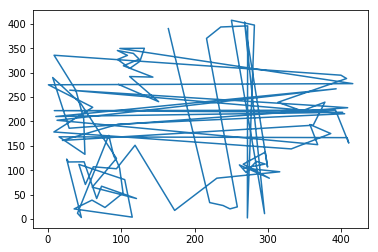

In [13]:
nbr=22 # indice du lipide que l'on suit
x=traj[:,nbr,0]
y=traj[:,nbr,1]
plt.plot(x,y)
print(x)

In [14]:
L = 430

x_ur = np.arange(nb_frames, dtype=float)
y_ur = np.arange(nb_frames, dtype=float)

x_ur[0] = x[0]
y_ur[0] = y[0]

for t in range(1,nb_frames):
    Dx = x[t]-x[t-1]
    if Dx < -L/2 :
        Dx = Dx+L
    if Dx > L/2 :
        Dx = Dx-L
    x_ur[t] = x_ur[t-1] + Dx
    
    Dy = y[t]-y[t-1]
    if Dy < -L/2 :
        Dy = Dy+L
    if Dy > L/2 :
        Dy = Dy-L
    y_ur[t] = y_ur[t-1] + Dy

[ 164.32000732  220.6000061   238.89001465  248.26002502  258.24002075
  216.29000854  235.72000122  272.33001709  271.95001221  281.52001953
  250.21002197  295.3500061   268.14001465  299.44003296  296.2800293
  266.25003052  301.88000488  261.07000732  270.11999512  284.17001343
  296.27001953  267.25        316.05001831  230.35002136  172.89001465
  118.94001007   93.56001282   62.1000061    51.27000427   42.4600029
  104.88000488  115.1000061    35.94000244   60.28000259   77.99000549
  102.6000061    97.91000366   94.27000427   89.98000336   83.13000488
   40.54000473   45.81000519   25.78000069   28.36000252   49.55000305
   66.6700058    73.31000519  120.88000488   60.61000443   93.63000488
   45.08000183    6.77000046   29.16000175  -21.42999458  -79.51001167
   29.98998833  -25.53997993   95.86999321   20.02998161  -68.40001106
  -52.42000008  -83.71000862 -116.37001228  -22.9599781   -30.58998299
    8.62998772   38.27998543   48.98998833   50.66999245   15.39998817
  -22.19

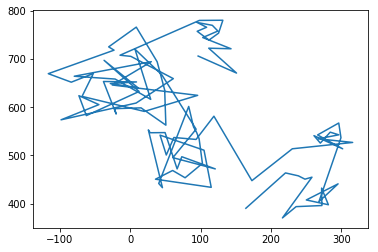

In [15]:
print(x_ur)
print(y_ur)
plt.plot(x_ur,y_ur)

In [16]:
# a voir si on prend à t ini ou quand le domaine est formé
nb_lipids = len(traj[0])
# a la frame initiale, tous les lipides, le lipide avec le plus grand x - le lipid avec le plus petit x
Lx = max(traj[0,:,0])-min(traj[0,:,0])
Ly = max(traj[0,:,1])-min(traj[0,:,1])

L=max(Lx,Ly)
print(L)

423.55002


In [17]:
x_ur = np.arange(nb_frames, dtype=float)
y_ur = np.arange(nb_frames, dtype=float)

smax = 10
#MSD = np.zeros(smax)
MSD_lipids = np.zeros(smax)
MSD_lipids_norm = np.zeros(smax)

for i in range (nb_lipids):
    
    x=traj[:,i,0]
    y=traj[:,i,1]

    x_ur[0] = x[0]
    y_ur[0] = y[0]
    
    for t in range(1,nb_frames):
        Dx = x[t]-x[t-1]
        if Dx < -L/2 :
            Dx = Dx+L
        if Dx > L/2 :
            Dx = Dx-L
        x_ur[t] = x_ur[t-1] + Dx

        Dy = y[t]-y[t-1]
        if Dy < -L/2 :
            Dy = Dy+L
        if Dy > L/2 :
            Dy = Dy-L
        y_ur[t] = y_ur[t-1] + Dy
        
    
    MSD = np.zeros(smax)
    for s in range(smax):
        for t in range(nb_frames-s):
            MSD[s] = MSD[s] + (x_ur[t+s]-x_ur[t])**2 + (y_ur[t+s]-y_ur[t])**2
        MSD[s]=MSD[s]/(nb_frames-s)
        MSD_lipids[s]=MSD_lipids[s]+MSD[s]
        
for s in range(smax):
    MSD_lipids_norm[s] = MSD_lipids[s]/nb_lipids
print(MSD_lipids_norm)

[    0.          2103.89567527  4101.29605742  6051.79446613
  7935.61764926  9808.5418883  11677.35705073 13523.3455062
 15369.5421599  17220.32069209]


[ 223.65463658 1901.22588399]


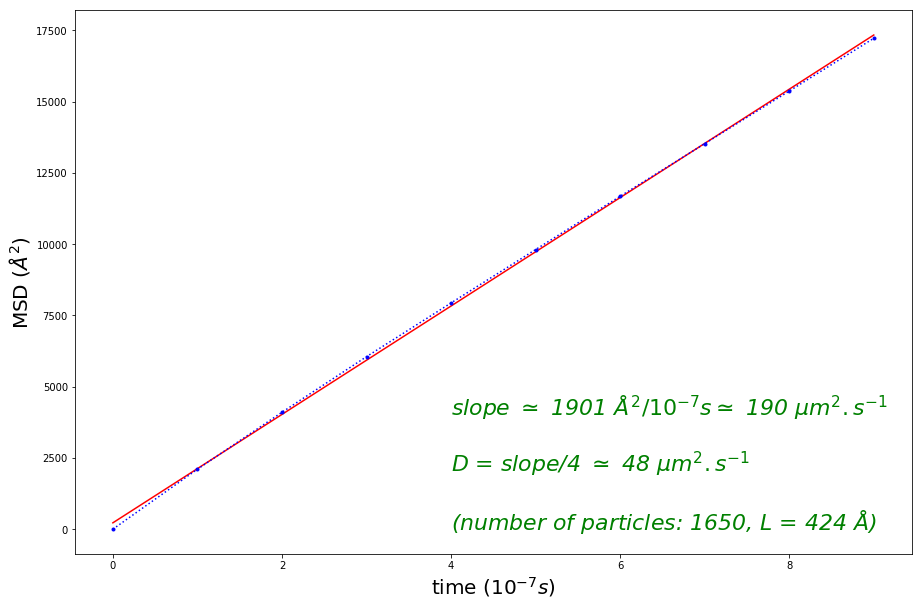

In [19]:
fig, ax = plt.subplots(figsize=(15, 10))

s = np.arange(smax)

pfit = P.polyfit(s, MSD_lipids_norm,1)
print(pfit)

ax.plot(s,pfit[1]*s+pfit[0], 'red')
ax.plot(s,MSD_lipids_norm, ':b.')
plt.xlabel('time ($10^{-7}s$)', fontsize=20)
plt.ylabel('MSD ($\AA^2$)', fontsize=20)
# *10e-8 pour micro m2 * 10e7 pour /s soit *10e-1 
plt.annotate('slope $\simeq $ %.0f $\AA^2/ 10^{-7}s$$\simeq $ %.0f $\mu m^2.s^{-1}$' % (pfit[1],pfit[1]*0.1), color='g', fontsize=22, style='italic', xy=(8,8), xytext=(4,4000))
plt.annotate('D = slope/4 $\simeq$ %.0f $\mu m^2.s^{-1}$' % (pfit[1]*0.1/4), color='g', fontsize=22, style='italic', xy=(8,8), xytext=(4,2000))
plt.annotate('(number of particles: %d, L = %.0f $\AA$)' % (nb_lipids, L), color='g', fontsize=22, style='italic', xy=(8,8), xytext=(4,0))

plt.savefig(path+'diffusion_DPPC'+name+'.pdf', format='pdf',bbox_inches='tight')

# Normal fluctuations

In [158]:
N = 15

nb_frames_simu = 10000
tmes = 500

nb_frames = int(nb_frames_simu/tmes)
h_t = np.zeros((N*N,nb_frames))

frame = 0

for ts in u.trajectory:
     if (ts.frame%tmes == 0):
            
            print(ts.frame)
                       
            xmin=0
            ymin=0
            str_sel= "(prop x> "+str(xmin)+" and prop y> "+str(ymin)+") and (name PO4 or name GM1)"
            patch = u.select_atoms(str_sel).positions
            
            xmax = max(patch[:,0])
            ymax = max(patch[:,1])
            
            xmin = min(patch[:,0])
            ymin = min(patch[:,1])
            
            dx = (xmax-xmin)/N
            dy = (ymax-ymin)/N
           
            Lf = mda.analysis.leaflet.LeafletFinder(u, 'name PO4 or name GM1')
            leaflet0 = Lf.groups(0)
            leaflet1 = Lf.groups(1)
            
            # leaflet 0 -----------------------------------------------------------------------------------------------------
            
            bary0 = []

            for i in range(0,N):
                xs = xmin + i*dx
                for j in range(0,N):
                    ys = ymin + j*dy

                    # barycenter of all molecules in each box
                    str_sel= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+")"
                    b0=leaflet0.select_atoms(str_sel).centroid().tolist()
                    bary0.append(b0)

            bary0=np.array(bary0)
            
            # leaflet 1 -----------------------------------------------------------------------------------------------------
            
            bary1 = []

            for i in range(0,N):
                xs = xmin + i*dx
                for j in range(0,N):
                    ys = ymin + j*dy

                    # barycenter of all molecules in each box
                    str_sel= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+")"
                    b1=leaflet1.select_atoms(str_sel).centroid().tolist()
                    bary1.append(b1)

            bary1=np.array(bary1)
            
            # median leaflet -----------------------------------------------------------------------------------------------------
            bary=(bary0+bary1)/2
            
            h_t[:,frame]=bary[:,2] # median leaflet height function
            
            frame+=1

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500


In [159]:
print(h_t[224,:])
print(nb_frames)

[54.57995415 48.76750278 55.84173203 47.00863743 46.94028282 50.11791897
 50.90009975 54.72245598 38.21981335 43.64250469 40.16227627 31.73087978
 43.03841209 46.83166504 23.87957239 24.36886525 47.92256737 40.01409435
 30.07227373 49.60013676]
20


In [162]:
smax = 10

h_co_box = np.zeros(smax)
h_co_box_norm = np.zeros(smax)

for i in range(N*N):
    h_co = np.zeros(smax)
    for s in range(smax):
        for t in range(nb_frames-s):
            h_co[s] = h_co[s] + h_t[i,t+s]*h_t[i,t]
        h_co[s] = h_co[s]/(nb_frames-s) - np.mean(h_t[i,:])**2 # a voir
        h_co_box[s] = h_co_box[s]+h_co[s]

for s in range(smax):
    h_co_box_norm[s] = h_co_box[s]/N/N
print(h_co_box_norm)

[ 56.15336764  -7.11836501  -5.3962268   -5.23868673 -12.98400428
 -12.04338433  -3.71762257   0.39040708  -0.96302055   3.50315969]


[5.61533768e+01 2.57348865e-02 3.26753307e-08]


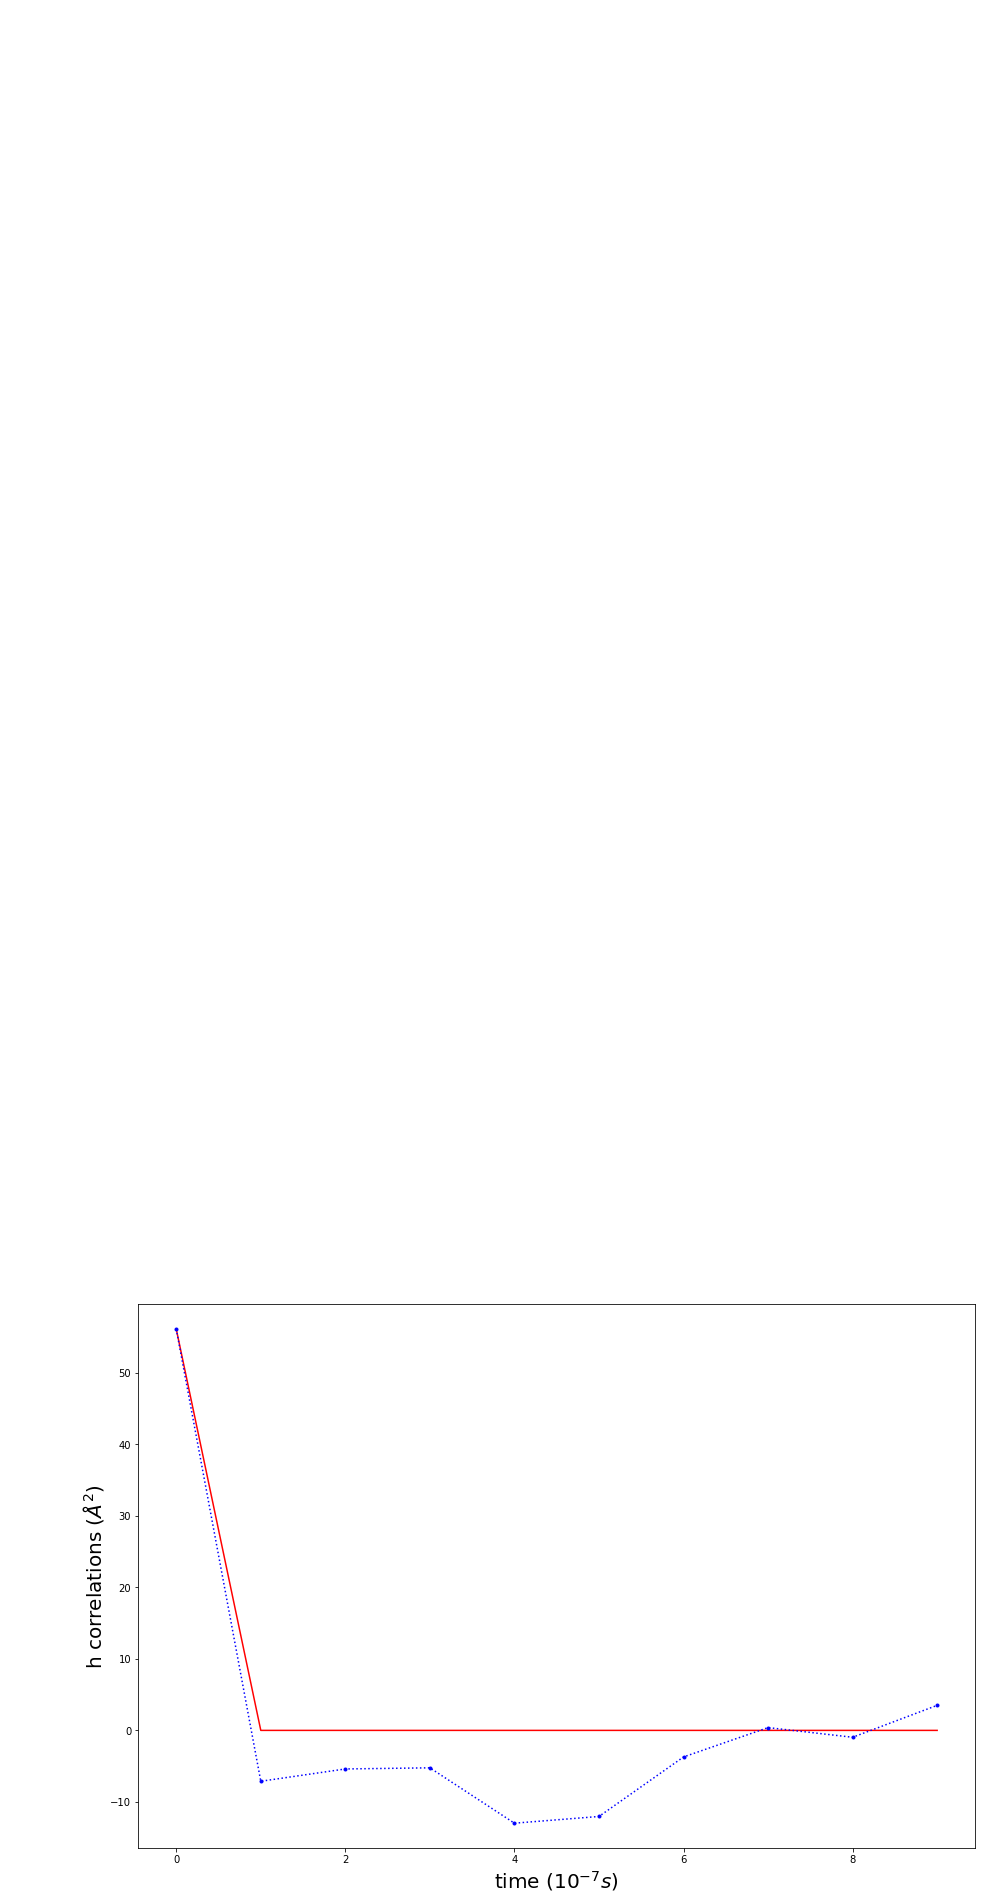

In [163]:
fig, ax = plt.subplots(figsize=(15, 10))

s = np.arange(smax)
y = h_co_box_norm

def fitFunc(t,A,tau,B):
        return A*np.exp(-t/tau) + B

param_bounds=([0,0,0],[5000,10,5000])

param, stat = curve_fit(fitFunc,s,y, bounds=param_bounds )

ax.plot(s,fitFunc(s, *param), 'red')
ax.plot(s,y, ':b.')

plt.xlabel('time ($10^{-7}s$)', fontsize=20)
plt.ylabel('h correlations ($\AA^2$)', fontsize=20)
# *10e-8 pour micro m2 * 10e7 pour /s soit *10e-1 
plt.annotate('$ \\tau \simeq %.2f$ $10^{-7}s $' % param[1], color='g', fontsize=22, style='italic', xy=(8,1910), xytext=(4,1910))
plt.annotate('(number of particles: %d, L=%.0f $\AA$)' % (nb_lipids, L), color='g', fontsize=22, style='italic', xy=(8,1905), xytext=(4,1905))
print(param)
plt.savefig(path+'h_correl'+name+'.pdf', format='pdf',bbox_inches='tight')